In [1]:
%load_ext autoreload
%autoreload 2

In [316]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import os
import pandas as pd
from datetime importa datetime
from matplotlib import pyplot as plt
from lopo_dataset import LopoDataset

In [3]:
df = pd.read_csv("../dataset_output/libras_minds/libras_minds_openpose_80_frames.csv")

In [4]:
df

,Unnamed: 0.1,Unnamed: 0,category,video_name,frame,hand_0_0_x,hand_0_0_y,hand_0_0_z,hand_0_1_x,hand_0_1_y,...,pose_22_y,pose_22_z,pose_23_x,pose_23_y,pose_23_z,pose_24_x,pose_24_y,pose_24_z,missing_hand,missing_face
0,1,1,Acontecer,01AcontecerSinalizador01-1.mp4,1,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
1,2,2,Acontecer,01AcontecerSinalizador01-1.mp4,2,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
2,3,3,Acontecer,01AcontecerSinalizador01-1.mp4,3,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False
3,5,5,Acontecer,01AcontecerSinalizador01-1.mp4,5,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False
4,6,6,Acontecer,01AcontecerSinalizador01-1.mp4,6,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92635,161434,8670,Vontade,20VontadeSinalizador12-5.mp4,162,0.614689,0.910987,0.588928,0.598457,0.922928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
92636,161435,8671,Vontade,20VontadeSinalizador12-5.mp4,163,0.614785,0.908597,0.584819,0.598921,0.922699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
92637,161436,8672,Vontade,20VontadeSinalizador12-5.mp4,164,0.614690,0.911093,0.602180,0.598085,0.925853,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
92638,161437,8673,Vontade,20VontadeSinalizador12-5.mp4,165,0.614768,0.910723,0.575162,0.599248,0.924518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False


In [5]:
# Minds only
if "person" not in df.columns:
    import re
    df["person"] = df["video_name"].apply(lambda i: int(re.findall(r".*Sinalizador(\d+)-.+.mp4", i)[0]))

In [6]:
frames = 80
people = df["person"].unique()
validate_people = people[-1:]
test_people = people[-2:-1]
train_people = people[:-2]

In [184]:
# dataset_dir = "../dataset_output/libras_minds/imgs_lopo/train"
train_dir = "../dataset_output/libras_minds/imgs_lopo/train/"
test_dir = "../dataset_output/libras_minds/imgs_lopo/test/"
validate_dir = "../dataset_output/libras_minds/imgs_lopo/validate/"

In [8]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [269]:
print("Processing train")
train_dataset = LopoDataset(df, frames, transform, person_in=train_people)
print("Processing test")
test_dataset = LopoDataset(df, frames, transform, augment=False, person_in=test_people)
print("Processing validate")
validate_dataset = LopoDataset(df, frames, transform, augment=False, person_in=validate_people)
print("Data loaded")

Processing train
Processing test
Processing validate
Data loaded


In [126]:
# Load dataset
# train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
# test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
# validate_dataset = datasets.ImageFolder(root=validate_dir, transform=transform)

In [97]:
# # Split dataset into train and test
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [270]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)

In [418]:
# Load pre-trained ResNet18 model
resnet = resnet18(pretrained=True)

/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [419]:
num_ftrs = resnet.fc.in_features

In [420]:
num_features = len(df["category"].unique())
num_features

20

In [378]:
# Modify the fully connected layer to match the number of classes
resnet.fc = nn.Linear(num_ftrs, num_features)

In [421]:
# Add an extra dense layer
resnet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, num_features)
)

In [422]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(resnet.parameters(), lr=10e-5)
optimizer = optim.Adam(resnet.parameters(), lr=10e-5, weight_decay=1e-5)

In [423]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [424]:
len(test_loader.dataset)

100

In [425]:
epochs = 15
history = {"loss": [], "accuracy": [], "val_accuracy": []}
best_val_loss = float('inf')
best_val_accuracy = 0
best_model_weights = resnet.state_dict()
patience = 5
counter = 0
for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    
    resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        val_loss = criterion(outputs, labels)
        history["loss"].append(float(loss))
        history["accuracy"].append(float(train_accuracy))
        history["val_accuracy"].append(float(val_accuracy))
        
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = resnet.state_dict()
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. No improvement in validation loss.")
            break

    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(str(datetime.now()))

Epoch 1/15, Train Loss: 2.9080, Train Accuracy: 0.1148, Validation Loss: 2.7529, Validation Accuracy: 0.1700
2024-03-30 17:14:12.962912
Epoch 2/15, Train Loss: 2.4319, Train Accuracy: 0.3539, Validation Loss: 2.0113, Validation Accuracy: 0.5000
2024-03-30 17:14:14.761402
Epoch 3/15, Train Loss: 1.7964, Train Accuracy: 0.6221, Validation Loss: 1.5057, Validation Accuracy: 0.6500
2024-03-30 17:14:16.583641
Epoch 4/15, Train Loss: 1.1865, Train Accuracy: 0.7891, Validation Loss: 1.1817, Validation Accuracy: 0.7300
2024-03-30 17:14:18.344095
Epoch 5/15, Train Loss: 0.7165, Train Accuracy: 0.9029, Validation Loss: 0.8937, Validation Accuracy: 0.7700
2024-03-30 17:14:20.177138
Epoch 6/15, Train Loss: 0.4466, Train Accuracy: 0.9520, Validation Loss: 0.4275, Validation Accuracy: 0.7700
2024-03-30 17:14:21.995526
Epoch 7/15, Train Loss: 0.2525, Train Accuracy: 0.9843, Validation Loss: 0.4875, Validation Accuracy: 0.8100
2024-03-30 17:14:23.798868
Epoch 8/15, Train Loss: 0.2082, Train Accuracy: 

In [426]:
# Load the best model weights
resnet.load_state_dict(best_model_weights)
print("Best val accuracy:", best_val_accuracy)

Best val accuracy: 0.88


In [427]:
resnet.eval()
correct = 0
total = 0
class_correct = list(0. for _ in range(num_features))
class_total = list(0. for _ in range(num_features))

In [428]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [429]:
# Evaluate on test set
resnet.eval()
correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = correct / total
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

In [430]:
print(f"Accuracy on the test set: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Accuracy on the test set: 0.9300
Precision: 0.9479, Recall: 0.9300, F1 Score: 0.9229


In [431]:
accuracy = correct / total
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9300


In [432]:
categories = [i+1 for i in range(num_features)]

In [433]:
precisions = []
for i in range(num_features):
    precision = class_correct[i] / class_total[i]
    precisions.append(precision)
    if precision < 1:
        print(f"Precision of class {i}: {precision:.4f}")
# plt.bar(categories, precision)

Precision of class 2: 0.4000
Precision of class 7: 0.4000
Precision of class 12: 0.8000


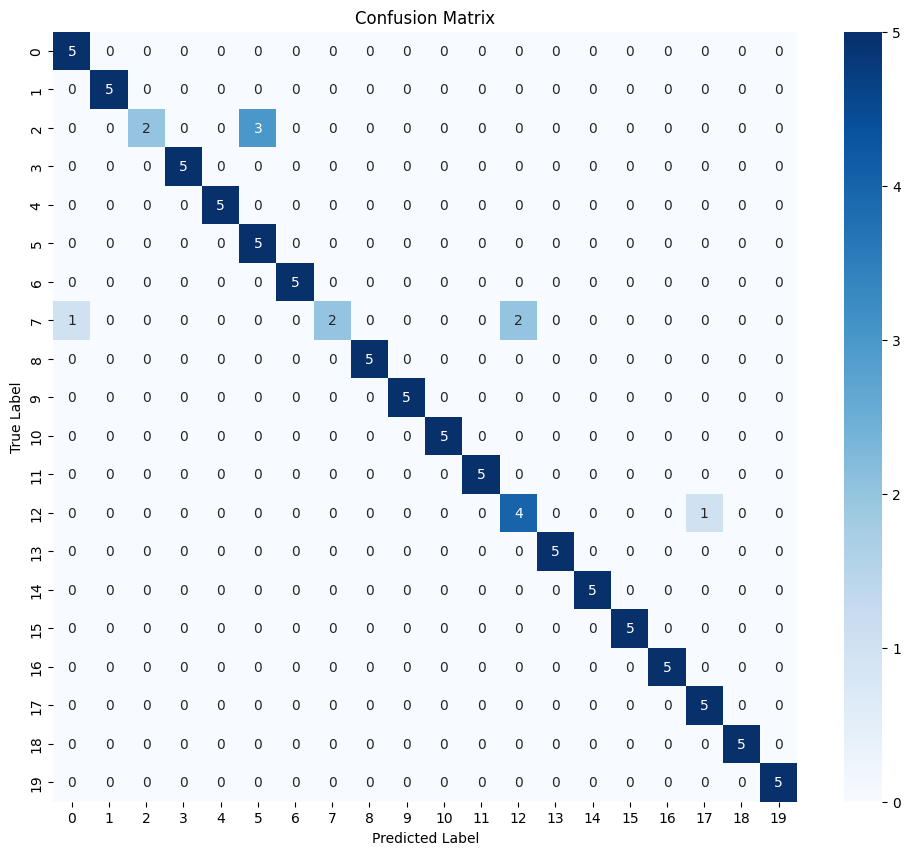

In [434]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [435]:
0.91 - accuracy

-0.020000000000000018

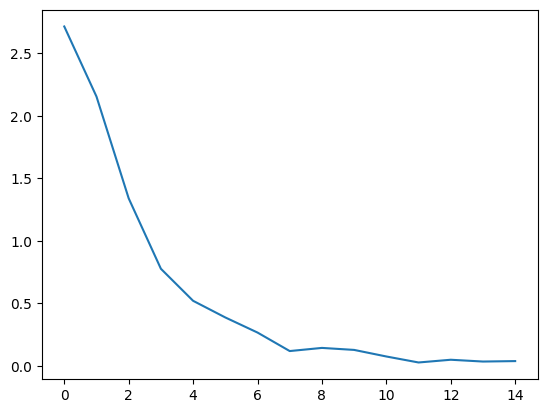

In [436]:
plt.plot(history["loss"])

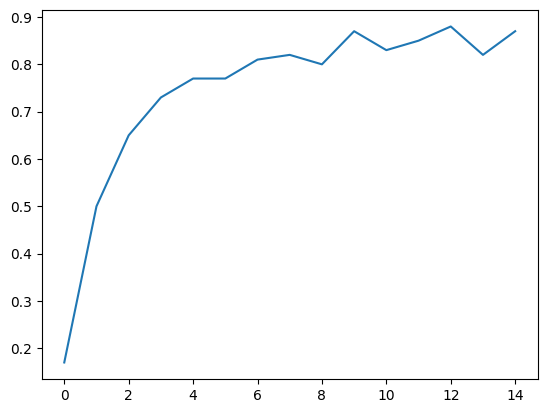

In [437]:
plt.plot(history["val_accuracy"])